<a href="https://colab.research.google.com/github/Dharamchandpatle/RefineryIQ/blob/master/IOCL_AnamolyDetectionAutomation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IOCL Anamoly Detection Automation

In [ ]:
# INSTALL & IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import smtplib
from email.message import EmailMessage



In [ ]:
# UPLOAD DATASET
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)


Saving refinery_energy_large_dataset.csv to refinery_energy_large_dataset.csv


In [ ]:
# =========================
# ONE-CELL DATA PIPELINE
# =========================

import pandas as pd
import numpy as np
from google.colab import files

# 1️⃣ Upload Dataset (Automation Trigger)
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_csv(file_name)
print("Dataset loaded:", file_name)

# 2️⃣ Remove Duplicates
df.drop_duplicates(inplace=True)

# 3️⃣ Handle Date Column Safely
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df[df["date"].notna()]

# 4️⃣ Handle Missing Values (Median – Robust)
df.fillna(df.median(numeric_only=True), inplace=True)

# 5️⃣ Remove Physically Impossible Values
df = df[
    (df["electricity_kwh"] > 0) &
    (df["steam_usage"] > 0) &
    (df["fuel_usage"] > 0) &
    (df["production_tons"] > 0)
]

# 6️⃣ Clip Noisy Sensor Data (NOT real anomalies)
df["electricity_kwh"] = df["electricity_kwh"].clip(400, 1600)
df["steam_usage"] = df["steam_usage"].clip(200, 900)
df["fuel_usage"] = df["fuel_usage"].clip(100, 700)

# 7️⃣ Feature Engineering – SEC
df["SEC"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
) / df["production_tons"]

# 8️⃣ Final Check
print("\nCleaned Dataset Info:")
df.info()

print("\nSample Data:")
df.head()


In [ ]:
# FEATURE ENGINEERING (SEC)
df["SEC"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
) / df["production_tons"]


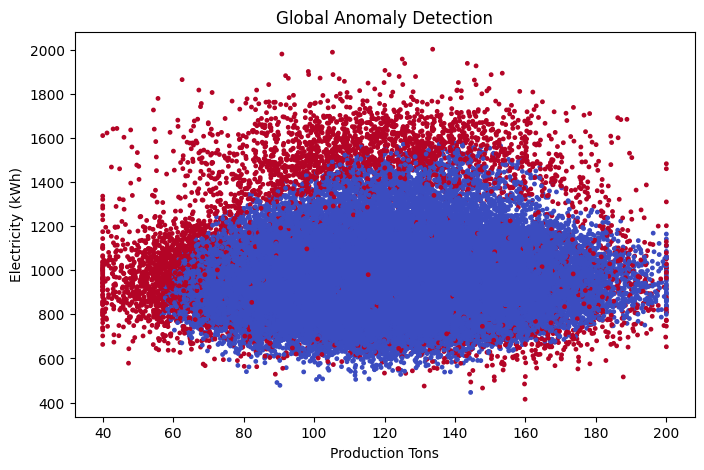

,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC,anomaly
0,21-10-2023 03:00,Hydrocracker,876.896024,451.883508,315.944364,129.774212,12.673734,0
1,05-02-2022 20:00,CDU,892.363227,583.108649,366.385274,151.946967,12.121711,0
2,06-10-2030 20:00,DCU,1038.607058,554.011158,157.918743,136.168086,12.855707,0
3,05-04-2028 22:00,CDU,808.311888,680.183209,304.637560,138.340268,12.961755,0
4,19-09-2022 01:00,CDU,997.376810,490.170735,337.180859,141.055837,12.936213,0


In [ ]:
# GLOBAL ANOMALY DETECTION
features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]

global_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

df["anomaly"] = np.where(global_model.fit_predict(X) == -1, 1, 0)


# GLOBAL ANOMALIES
plt.figure(figsize=(8,5))
plt.scatter(df["production_tons"], df["electricity_kwh"],
            c=df["anomaly"], cmap="coolwarm", s=6)
plt.title("Global Anomaly Detection")
plt.xlabel("Production Tons")
plt.ylabel("Electricity (kWh)")
plt.show()
df.head()

In [ ]:
# UNIT-WISE ANOMALY DETECTION
unit_dfs = {}
unit_models = {}

for unit in df["unit_name"].unique():
    unit_df = df[df["unit_name"] == unit].copy()

    model = IsolationForest(
        n_estimators=100,
        contamination=0.05,
        random_state=42
    )

    unit_df["anomaly"] = np.where(
        model.fit_predict(unit_df[features]) == -1, 1, 0
    )

    unit_dfs[unit] = unit_df
    unit_models[unit] = model

    # df.head()


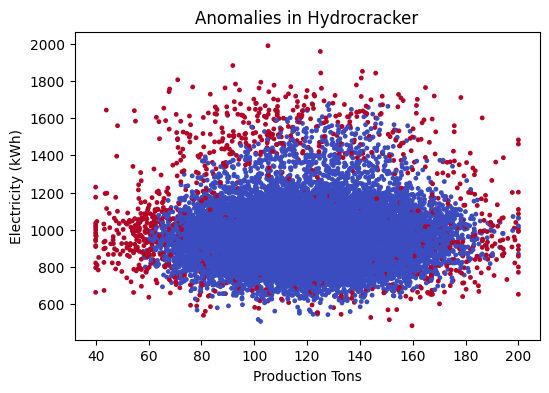

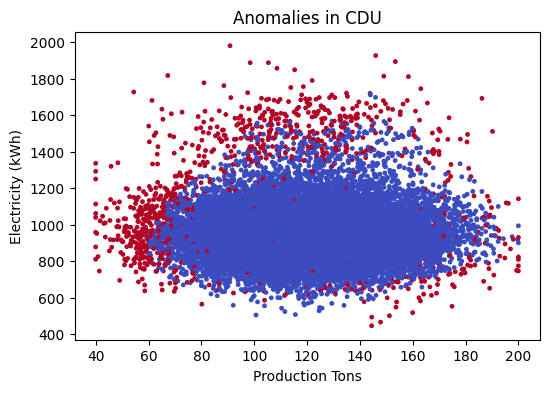

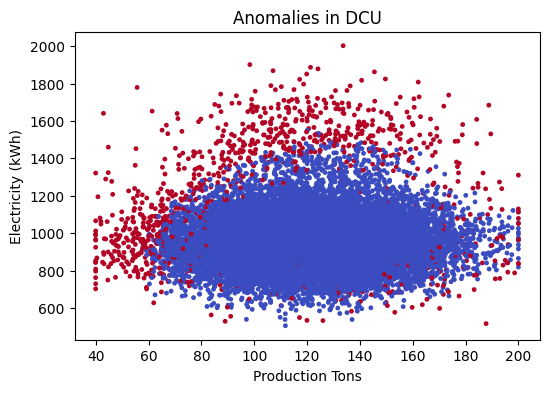

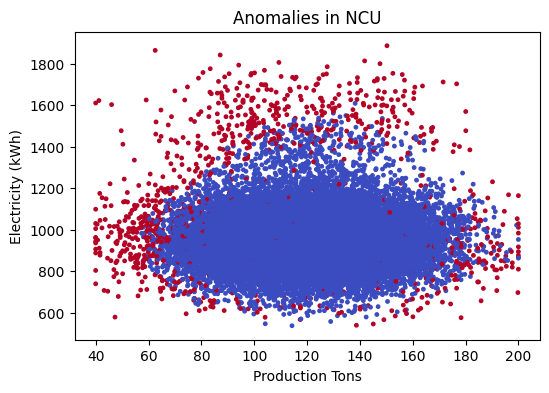

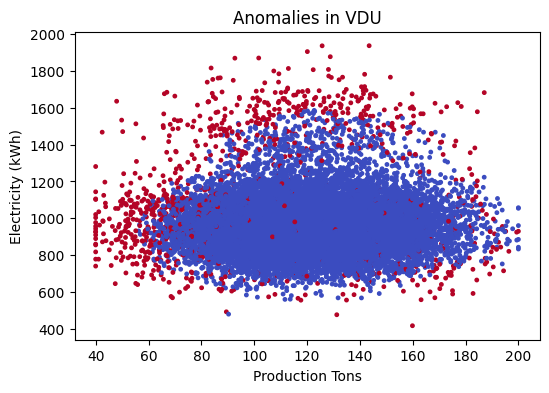

In [ ]:
# UNIT-WISE PLOTS
for unit, unit_df in unit_dfs.items():
    plt.figure(figsize=(6,4))
    plt.scatter(
        unit_df["production_tons"],
        unit_df["electricity_kwh"],
        c=unit_df["anomaly"],
        cmap="coolwarm",
        s=6
    )
    plt.title(f"Anomalies in {unit}")
    plt.xlabel("Production Tons")
    plt.ylabel("Electricity (kWh)")
    plt.show()
    # df.head()


In [ ]:
for unit, unit_df in unit_dfs.items():
    print(unit, unit_df.columns)


Hydrocracker Index(['date', 'unit_name', 'electricity_kwh', 'steam_usage', 'fuel_usage',
       'production_tons', 'SEC', 'anomaly'],
      dtype='object')
CDU Index(['date', 'unit_name', 'electricity_kwh', 'steam_usage', 'fuel_usage',
       'production_tons', 'SEC', 'anomaly'],
      dtype='object')
DCU Index(['date', 'unit_name', 'electricity_kwh', 'steam_usage', 'fuel_usage',
       'production_tons', 'SEC', 'anomaly'],
      dtype='object')
NCU Index(['date', 'unit_name', 'electricity_kwh', 'steam_usage', 'fuel_usage',
       'production_tons', 'SEC', 'anomaly'],
      dtype='object')
VDU Index(['date', 'unit_name', 'electricity_kwh', 'steam_usage', 'fuel_usage',
       'production_tons', 'SEC', 'anomaly'],
      dtype='object')


In [ ]:
SEC_mean = df["SEC"].mean()

def calculate_severity(sec):
    if sec > 1.5 * SEC_mean:
        return "HIGH"
    elif sec > 1.2 * SEC_mean:
        return "MEDIUM"
    else:
        return "LOW"


In [ ]:
# Apply severity unit-wise


for unit, unit_df in unit_dfs.items():
    unit_df["severity"] = np.where(
        unit_df["anomaly"] == 1,
        unit_df["SEC"].apply(calculate_severity),
        "NORMAL"
    )
    unit_dfs[unit] = unit_df

In [ ]:
# MERGE ALL UNITS (ALERTS DATAFRAME)
alerts_df = pd.concat(unit_dfs.values(), ignore_index=True)
alerts_df = alerts_df[alerts_df["anomaly"] == 1]


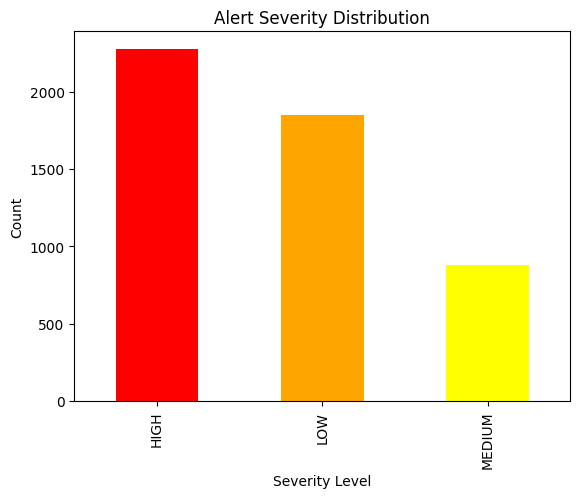

In [ ]:
# SEVERITY DISTRIBUTION
# SEVERITY DISTRIBUTION PLOT 📊

alerts_df["severity"].value_counts().plot(
    kind="bar",
    title="Alert Severity Distribution",
    color=["red", "orange", "yellow"]
)
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()


SEND AUTOMATED GMAIL ALERT

In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
os.listdir()


['.config', 'refinery_energy_large_dataset.csv', 'sample_data']

In [ ]:
# Create alert report again (safe)
alerts_df.to_csv("refinery_alert_report.csv", index=False)

print("File created:", os.path.exists("refinery_alert_report.csv"))


File created: True


In [ ]:
import smtplib
from email.message import EmailMessage

EMAIL = "dharambaba2k4@gmail.com"
APP_PASSWORD = "fugmkuhfxtzeutjm"

msg = EmailMessage()
msg["Subject"] = "🚨 Automated Refinery Energy Anomaly Report"
msg["From"] = EMAIL
msg["To"] = "dharamcodemystery@gmail.com"
msg.set_content("Attached is the automated anomaly alert report.")

with open("refinery_alert_report.csv", "rb") as f:
    msg.add_attachment(
        f.read(),
        maintype="application",
        subtype="octet-stream",
        filename="refinery_alert_report.csv"
    )

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(EMAIL, APP_PASSWORD)
    server.send_message(msg)

print("✅ Automated alert email sent!")


✅ Automated alert email sent!


In [ ]:
import os

files_to_delete = [
    "refinery_energy_large_dataset (1).csv",
    "refinery_energy_large_dataset (2).csv",
    "refinery_energy_large_dataset (3).csv"
]

for file in files_to_delete:
    path = f"/content/{file}"
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {file}")
    else:
        print(f"Not found: {file}")


Not found: refinery_energy_large_dataset (1).csv
Not found: refinery_energy_large_dataset (2).csv
Not found: refinery_energy_large_dataset (3).csv
